In [1]:
from NeuralNetwork import NeuralNet
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
from jax import jit
from plotutils import plotHeatmap
import pandas as pd

In [2]:
@jit
def FrankeFunction(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Franke's function for evaluating methods.

    inputs:
        x (np.array): values in x direction

        y (np.array): values in y direction

    returns:
        (np.array) values in z direction
    """

    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) -
                          0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-((9 * x - 7) ** 2) / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-((9 * x - 4) ** 2) - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

In [3]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y).reshape(-1, 1)
X = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))

I0000 00:00:1700391935.569708       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
values = (X_train, X_test, z_train, z_test)

In [5]:
from typing import Callable
from CostFuncs import CostOLS_fast
from Schedules import Scheduler
from Activators import sigmoid, identity
from NeuralNetwork import NeuralNet
from pathlib import Path
from plotutils import plot_Franke, plot_validation_train

basePath = Path.cwd().parent.parent / "figures/franke"


def generate_and_plot(
    dims: tuple[int],
    lmbda: float,
    scheduler: Scheduler,
    schedule_params: tuple,
    hidden_func: Callable,
    cost_func: Callable = CostOLS_fast,
    savePlots: bool = False,
    showPlots: bool = True,
    figsPath: Path = None,
    saveName: str = None,
):
    dimensions = (2, *dims, 1)
    FFNN = NeuralNet(dimensions, hidden_func, identity, cost_func, seed=2023)
    scores = FFNN.fit(
        X_train,
        z_train,
        scheduler(*schedule_params),
        batches=40,
        epochs=100,
        lmbda=lmbda,
        X_val=X_test,
        target_val=z_test,
    )
    plot_Franke(
        FFNN,
        x,
        y,
        z,
        title=rf"Franke's function ({hidden_func.__name__}) ($\lambda$={lmbda}) ({scheduler.__name__}({schedule_params}))",
        savePlots=savePlots,
        showPlots=showPlots,
        figsPath=figsPath,
        saveName=saveName,
    )
    plot_validation_train(
        scores,
        title=f"SGD ({hidden_func.__name__}, {scheduler.__class__.__name__})",
        savePlots=savePlots,
        showPlots=showPlots,
        figsPath=figsPath,
        saveName=saveName,
    )


def generate_results(lmbda_arr, eta_arr, schedule: Scheduler, hidden_func: Callable):
    train_res = onp.zeros((len(lmbda_arr), len(eta_arr)))
    validation_res = onp.zeros((len(lmbda_arr), len(eta_arr)))
    for i, lmbda in enumerate(lmbda_arr):
        for j, eta in enumerate(eta_arr):
            FFNN = NeuralNet(
                (2, 75, 75, 100, 1), hidden_func, identity, CostOLS_fast, seed=2023
            )
            schedule.eta = eta
            scores = FFNN.fit(
                X_train,
                z_train,
                scheduler=schedule,
                batches=40,
                epochs=100,
                lmbda=lmbda,
                X_val=X_test,
                target_val=z_test,
            )
            train_res[i, j] = scores["train_errors"][-1]
            validation_res[i, j] = scores["validation_errors"][-1]
    return train_res, validation_res


def create_heatmaps(
    train_res: np.ndarray,
    validation_res: np.ndarray,
    scheduleName: str,
    funcName: str,
    lmbda_arr: np.ndarray,
    eta_arr: np.ndarray,
):
    schedulePath = basePath / scheduleName.lower()
    schedulePath.mkdir(parents=True, exist_ok=True)
    train_df = pd.DataFrame(
        np.log10(train_res),
        index=lmbda_arr,
        columns=eta_arr,
    )
    validation_df = pd.DataFrame(
        np.log10(validation_res),
        index=lmbda_arr,
        columns=eta_arr,
    )
    plotHeatmap(
        train_df,
        title=f"Train error {scheduleName.title()} ({funcName})",
        savePlots=True,
        showPlots=True,
        figsPath=schedulePath,
        saveName=f"{funcName.lower()}_train_error_heatmap",
    )
    plotHeatmap(
        validation_df,
        title=f"Validation error {scheduleName.title()} ({funcName})",
        savePlots=True,
        showPlots=True,
        figsPath=schedulePath,
        saveName=f"{funcName.lower()}_validation_error_heatmap",
    )

In [9]:
def do_stuff(low_lmbda, high_lmbda, eta_arr, scheduler, func):
    count = high_lmbda - low_lmbda + 1
    if count > 6:
        print(
            f"WARNING: Attempting to run with {count} lambdas. This may take a while."
        )
    lmbda_arr = np.logspace(low_lmbda, high_lmbda, high_lmbda - low_lmbda + 1)
    train_res, validation_res = generate_results(
        lmbda_arr, eta_arr, scheduler, func)
    create_heatmaps(
        train_res,
        validation_res,
        scheduler.__class__.__name__.title(),
        func.__name__,
        lmbda_arr,
        eta_arr,
    )

100%|██████████| 4000/4000 [00:09<00:00, 426.86it/s]


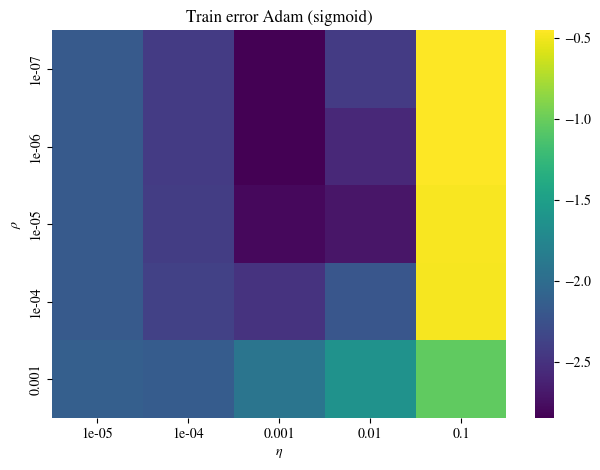

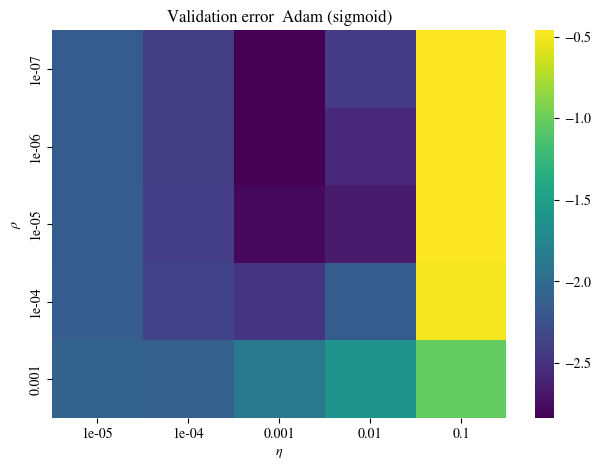

100%|██████████| 4000/4000 [00:08<00:00, 454.69it/s]


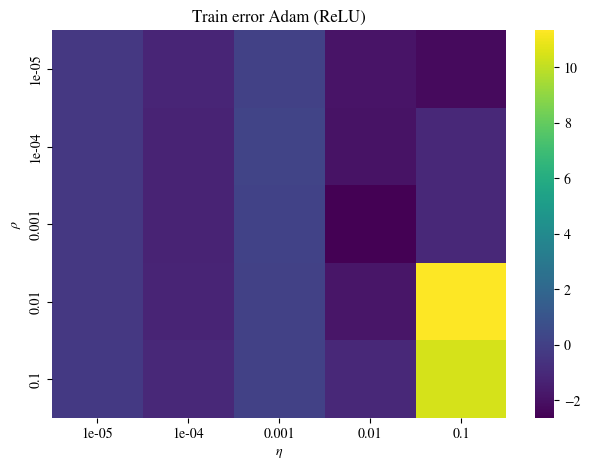

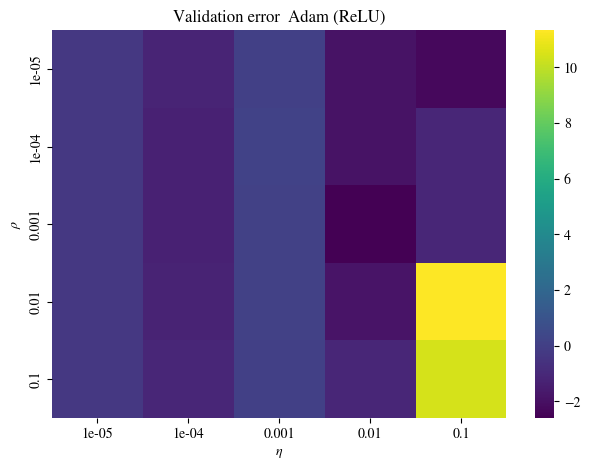

100%|██████████| 4000/4000 [00:09<00:00, 437.89it/s]


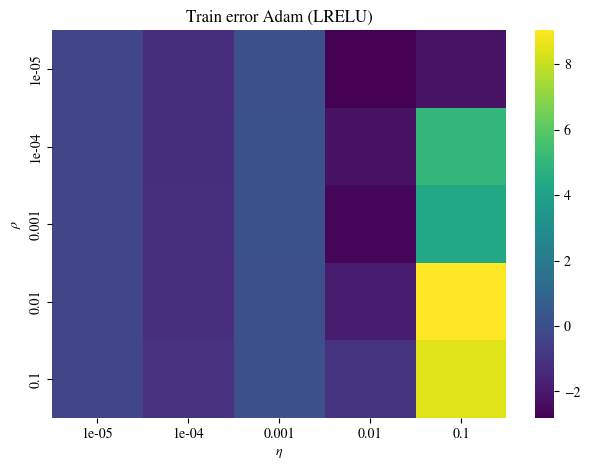

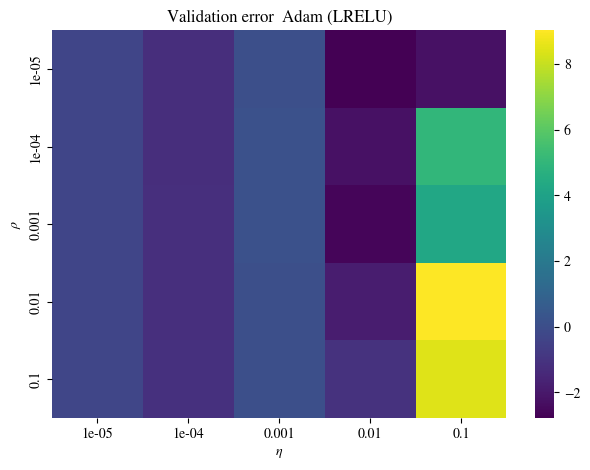

In [12]:
# Adam passes:
from Schedules import Adam
from Activators import sigmoid, ReLU, LRELU

low_arr = [-7, -5, -5]
high_arr = [-3, -1, -1]
eta_arr = np.logspace(-5, -1, 5)
funcs = [sigmoid, ReLU, LRELU]
for low, high, func in zip(low_arr, high_arr, funcs):
    do_stuff(low, high, eta_arr, Adam(0, 0.9, 0.999), func)

100%|██████████| 4000/4000 [00:09<00:00, 425.79it/s]


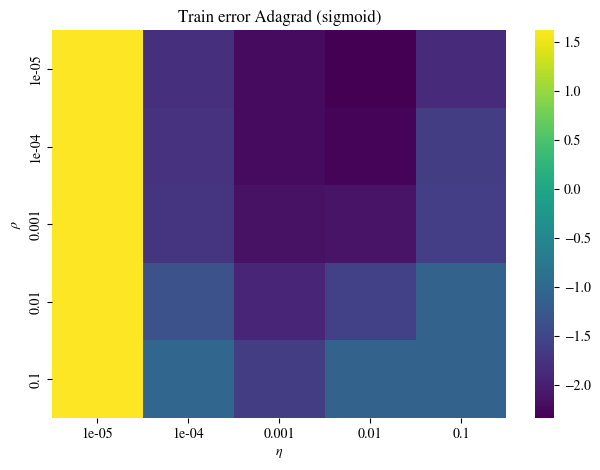

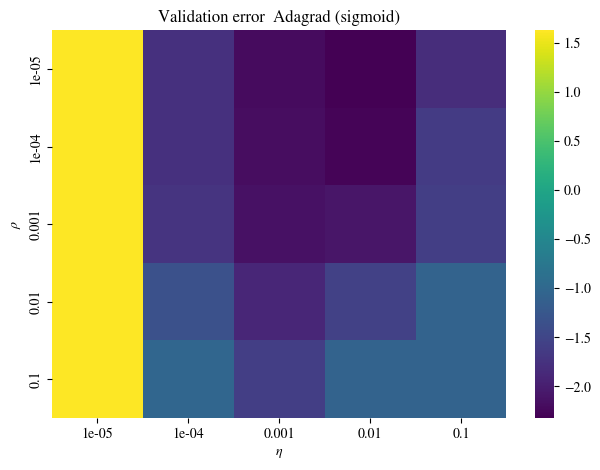

100%|██████████| 4000/4000 [00:08<00:00, 459.21it/s]


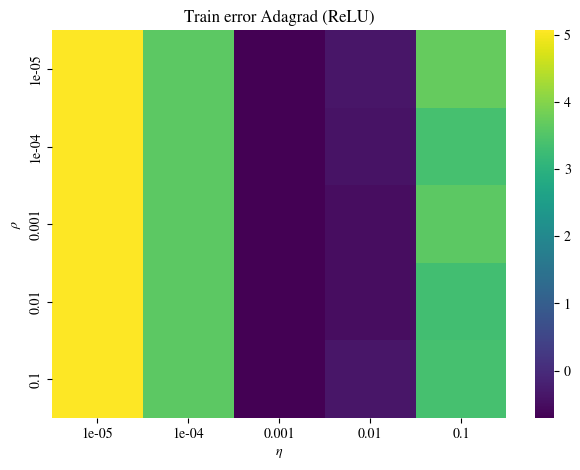

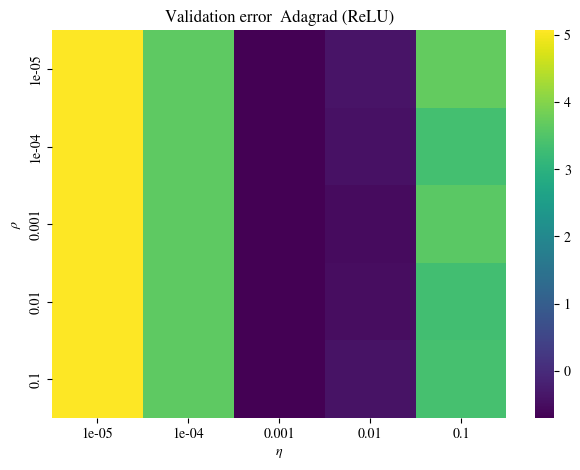

100%|██████████| 4000/4000 [00:09<00:00, 415.98it/s]


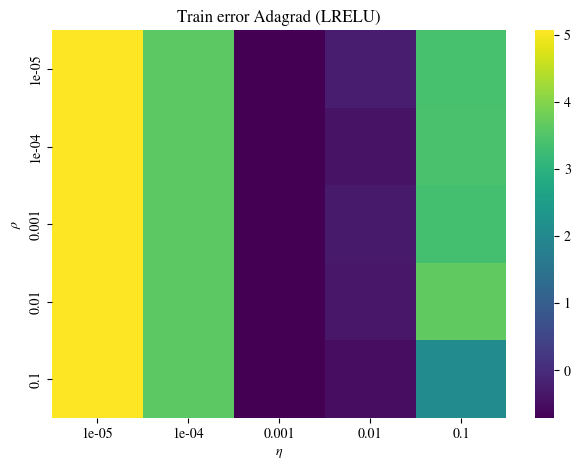

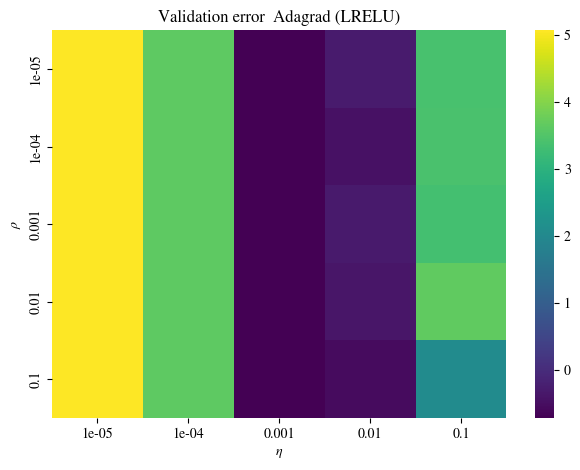

In [13]:
# Adagrad passes:
from Schedules import Adagrad

low_arr = [-5, -5, -5]
high_arr = [-1, -1, -1]
eta_arr = np.logspace(-5, -1, 5)
funcs = [sigmoid, ReLU, LRELU]
for low, high, func in zip(low_arr, high_arr, funcs):
    do_stuff(low, high, eta_arr, Adagrad(0), func)

100%|██████████| 4000/4000 [00:09<00:00, 419.22it/s]


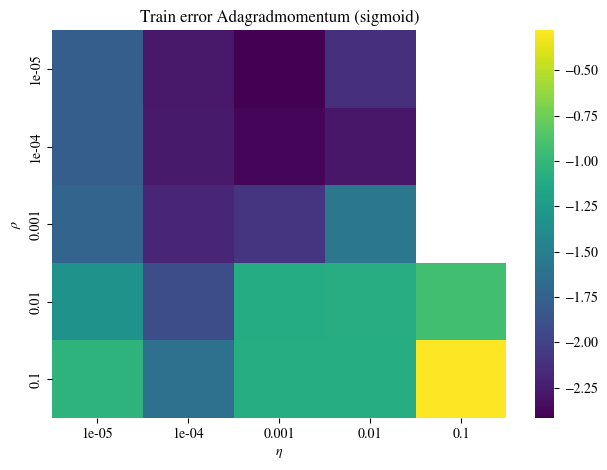

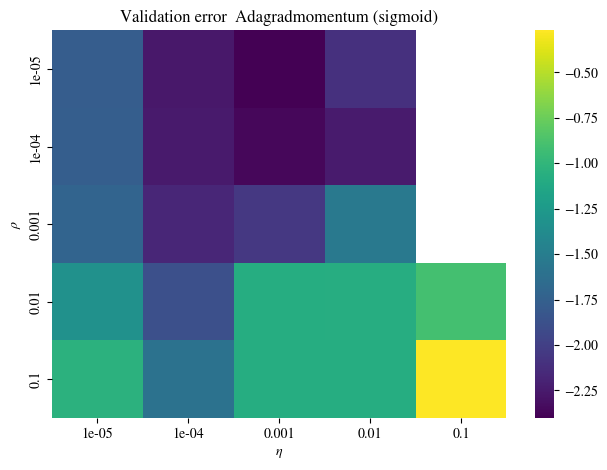

100%|██████████| 4000/4000 [00:08<00:00, 445.58it/s]


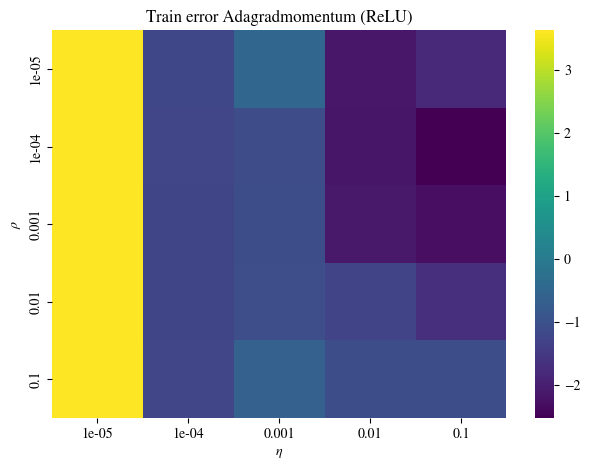

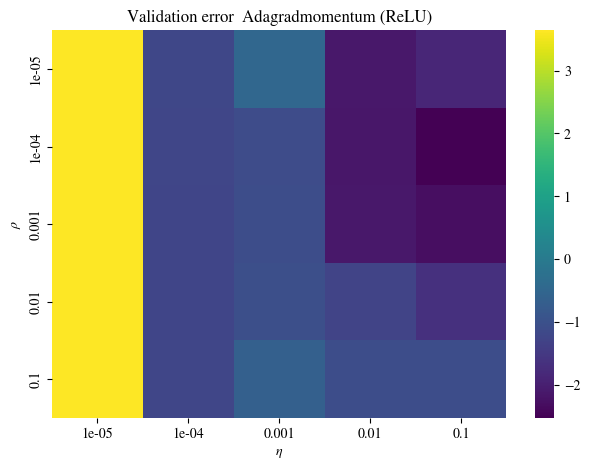

100%|██████████| 4000/4000 [00:10<00:00, 366.38it/s]


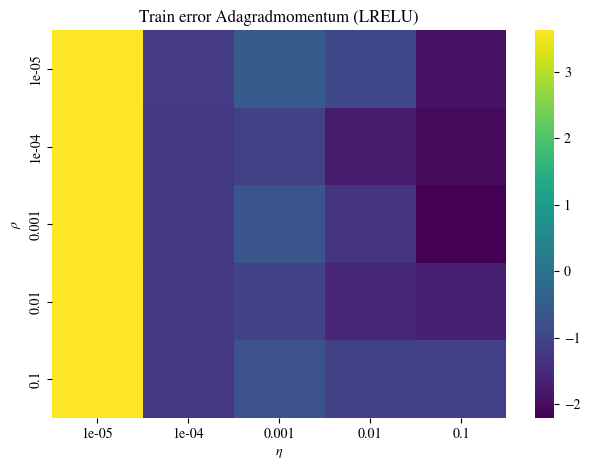

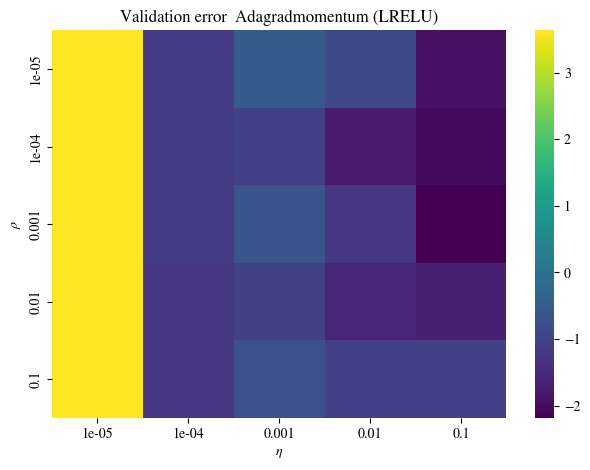

In [14]:
# AdagradMomentum passes:
from Schedules import AdagradMomentum

low_arr = [-5, -5, -5]
high_arr = [-1, -1, -1]
eta_arr = np.logspace(-5, -1, 5)
funcs = [sigmoid, ReLU, LRELU]
for low, high, func in zip(low_arr, high_arr, funcs):
    do_stuff(low, high, eta_arr, AdagradMomentum(0, 0.9), func)

100%|██████████| 4000/4000 [00:10<00:00, 370.59it/s]


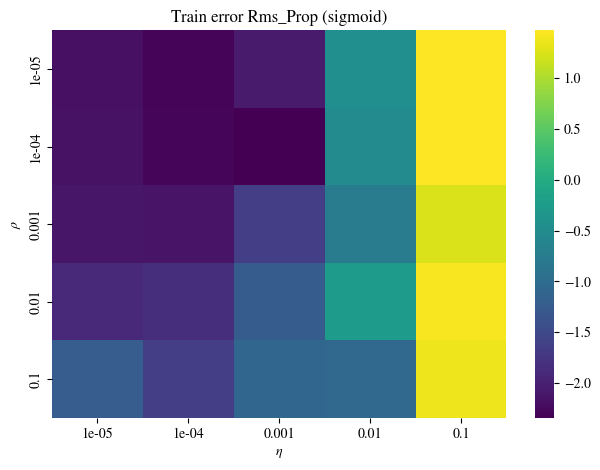

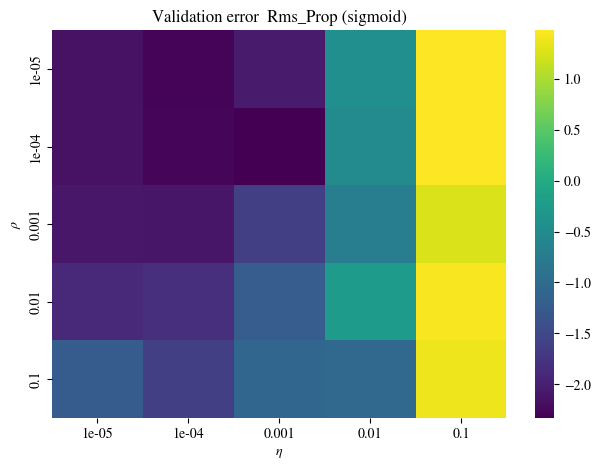

100%|██████████| 4000/4000 [00:08<00:00, 464.55it/s]


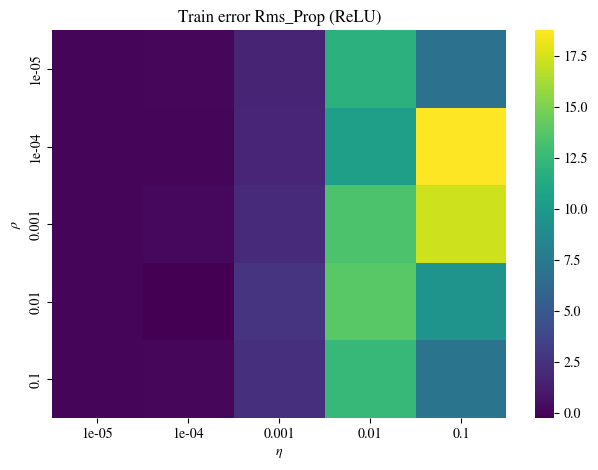

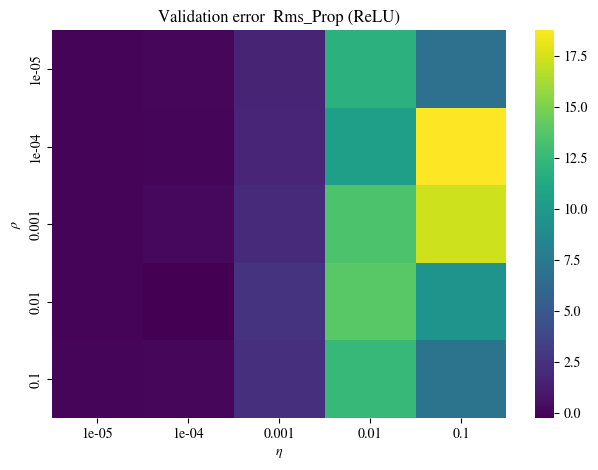

100%|██████████| 4000/4000 [00:08<00:00, 481.77it/s]


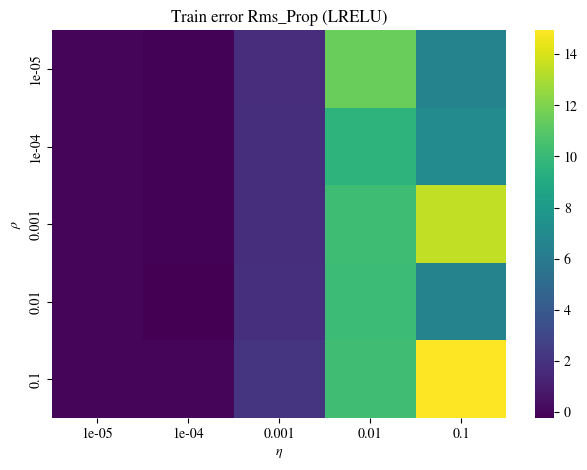

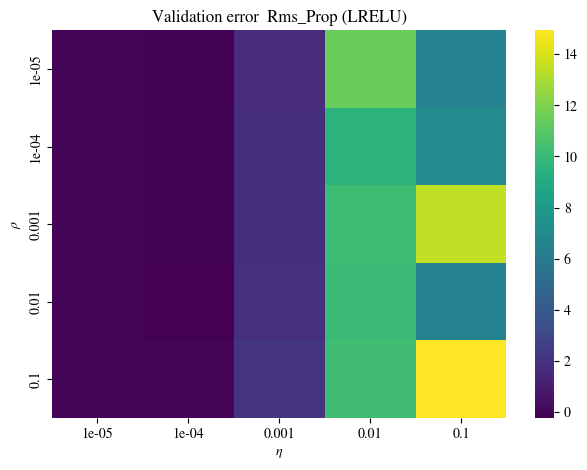

In [15]:
# RMSprop passes:
from Schedules import RMS_prop

low_arr = [-5, -5, -5]
high_arr = [-1, -1, -1]
eta_arr = np.logspace(-5, -1, 5)
funcs = [sigmoid, ReLU, LRELU]
for low, high, func in zip(low_arr, high_arr, funcs):
    do_stuff(low, high, eta_arr, RMS_prop(0, 0.9), func)

100%|██████████| 4000/4000 [00:09<00:00, 426.55it/s]


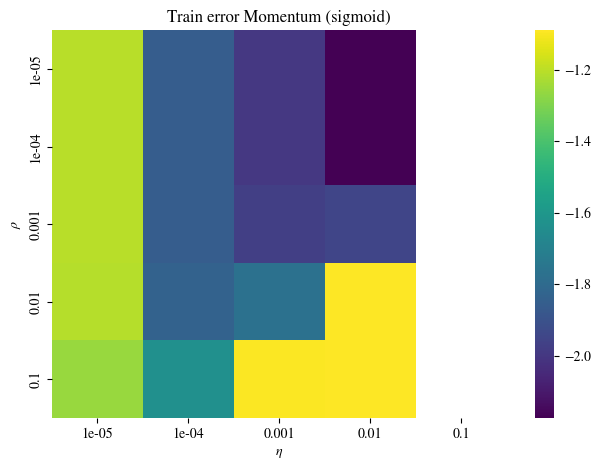

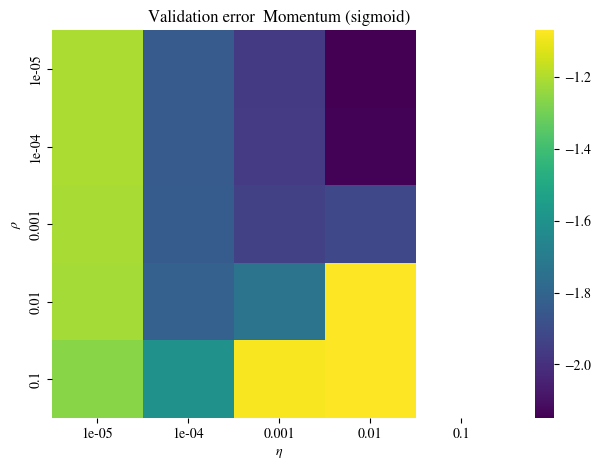

100%|██████████| 4000/4000 [00:11<00:00, 347.20it/s]
/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


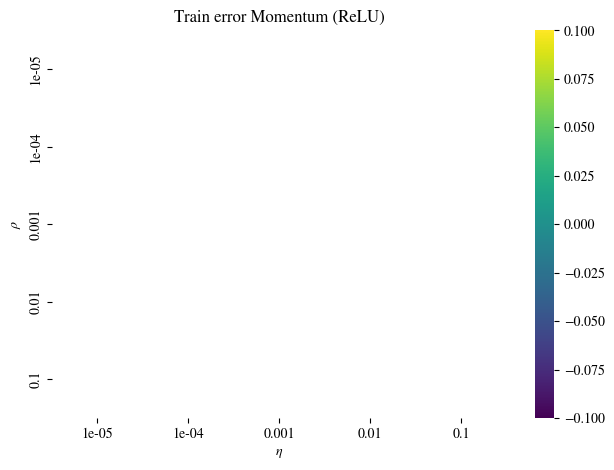

/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


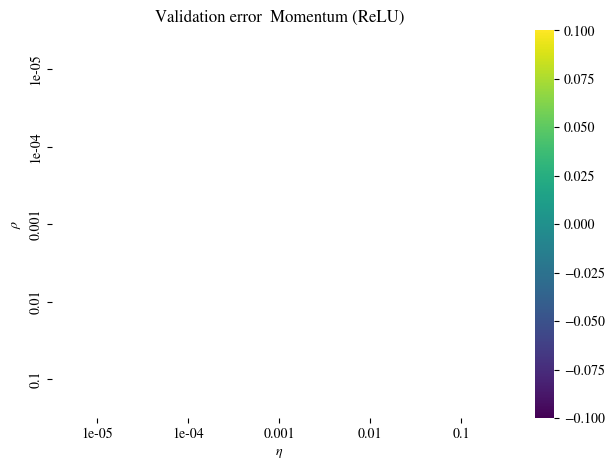

100%|██████████| 4000/4000 [00:08<00:00, 474.96it/s]
/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


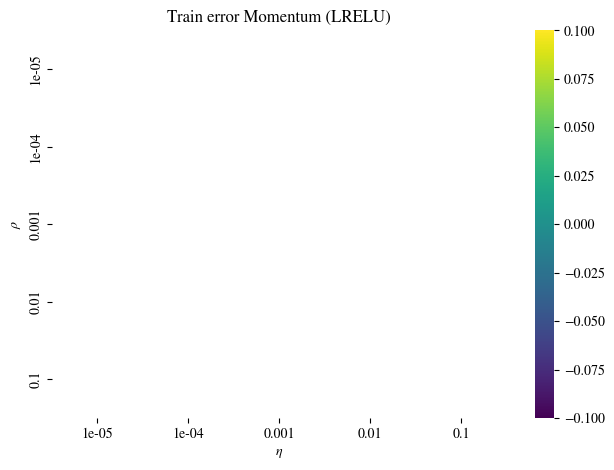

/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


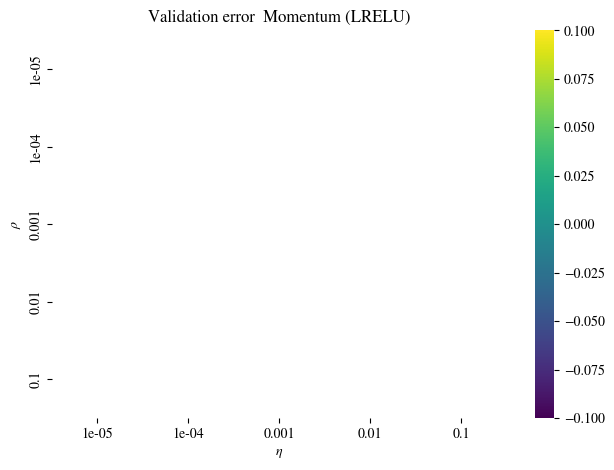

In [16]:
# RMSprop passes:
from Schedules import Momentum

low_arr = [-5, -5, -5]
high_arr = [-1, -1, -1]
eta_arr = np.logspace(-5, -1, 5)
funcs = [sigmoid, ReLU, LRELU]
for low, high, func in zip(low_arr, high_arr, funcs):
    do_stuff(low, high, eta_arr, Momentum(0, 0.9), func)

100%|██████████| 4000/4000 [00:08<00:00, 448.15it/s]


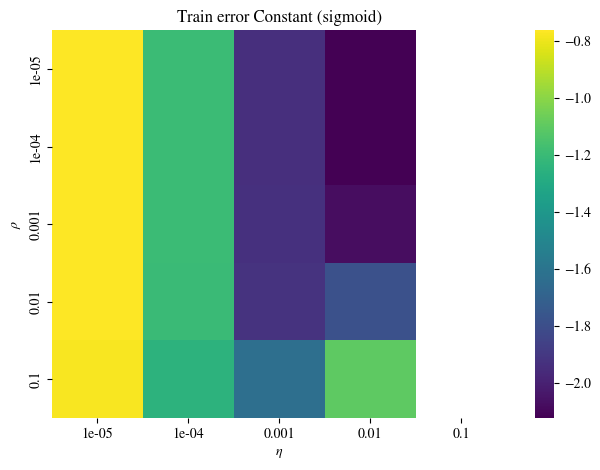

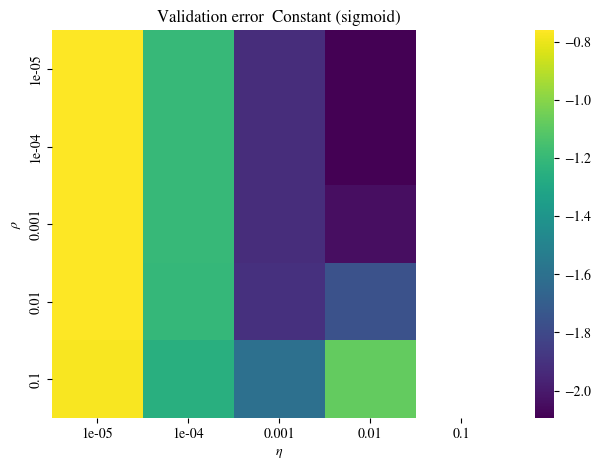

100%|██████████| 4000/4000 [00:08<00:00, 461.73it/s]
/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


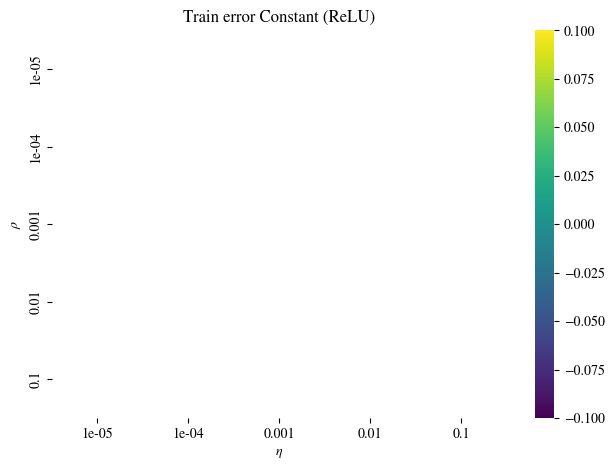

/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


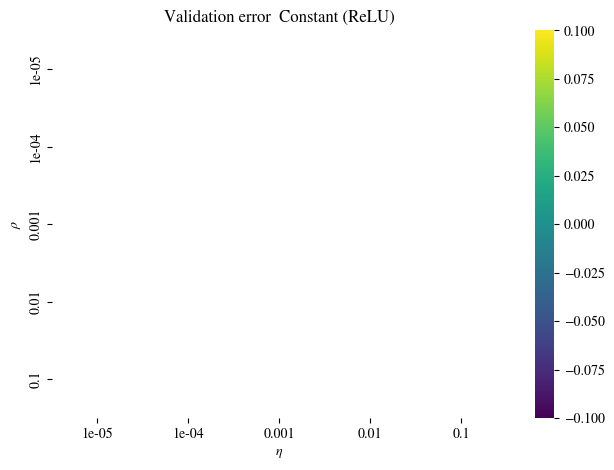

100%|██████████| 4000/4000 [00:09<00:00, 413.56it/s]
/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


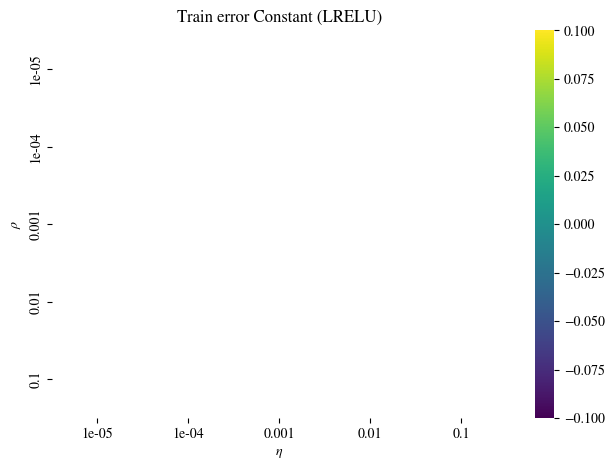

/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


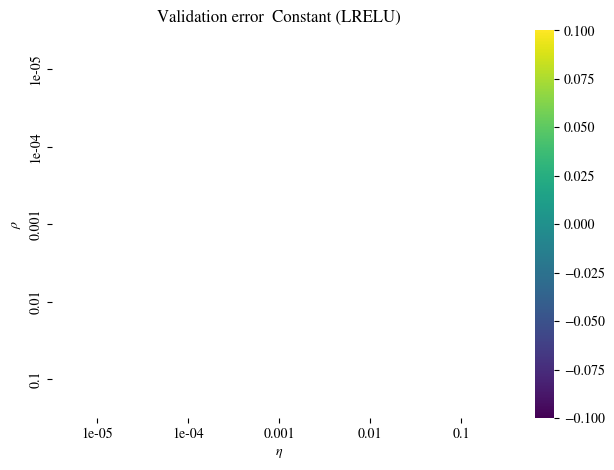

In [18]:
# RMSprop passes:
from Schedules import Constant

low_arr = [-5, -5, -5]
high_arr = [-1, -1, -1]
eta_arr = np.logspace(-5, -1, 5)
funcs = [sigmoid, ReLU, LRELU]
for low, high, func in zip(low_arr, high_arr, funcs):
    do_stuff(low, high, eta_arr, Constant(0), func)

In [ ]:
from Activators import zero_one_clip

low_arr = [-5, -5, -5]
high_arr = [-1, -1, -1]
eta_arr = np.logspace(-5, -1, 5)
schedulers = [
    Constant(0),
    Momentum(0, 0.9),
    Adagrad(0),
    AdagradMomentum(0, 0.9),
    RMS_prop(0, 0.9),
    Adam(0, 0.9, 0.999),
]
for low, high, scheduler in zip(low_arr, high_arr, schedulers):
    do_stuff(low, high, eta_arr, scheduler, zero_one_clip)

### Adam
- sigmoid -3

### Adagrad
- sigmoid -2.5

### AdagradMomentum
- ReLU -2.5

### RMSprop
- sigmoid -2.5

### Momentum
- sigmoid - -2.5

### Constant
- sigmoid -2